In [1]:
#Environment
import numpy as np
from enum import Enum
from keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)

class Team(Enum):
    CT = 0
    T = 1
    
class Direction(Enum):
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4

class Board:
    def __init__(self):
        self.size = 10
        self.players = [] #Define a list of players on the map
        self.boxes = [] #Define a list for the boxes on the map
        self.observation = np.zeros((2, 2*self.size, 2*self.size))
        self.timer = 10000
        self.bomb = None
        self.defused = False
    
    def init_observation(self):
        new_obs = np.zeros((2, 2*self.size, 2*self.size))
        for i in range(int(self.size*2)):
            t_x = i - self.size
            for j in range(int(self.size*2)):
                t_y = j - self.size
                if self.in_bombsite(t_x, t_y):
                    new_obs[1][j][i] = -0.5
                
                for player in self.players:
                    if t_x == player.x and t_y == player.y:
                        if player.team == Team.T:
                            new_obs[0][j][i] = -0.1
                        else:
                            new_obs[0][j][i] = -0.5
                        break
                    else:
                        new_obs[0][j][i] = 1
                
                
                for box in self.boxes:
                    if box.in_box(t_x, t_y):
                        val = 1
                        if box.passable:
                            val = 0.5
                        
                        if box.bomb:
                            val = -1

                        new_obs[1][j][i] = val
                        new_obs[0][j][i] = 0
                        break
        self.observation = new_obs
        return new_obs
                        
    def in_bombsite(self, objectx, objecty):
        if objectx <= -5 and objectx >= -8:
            if objecty <= -2 and objecty >= -6:
                return True
        elif objectx <= 10 and objectx >= 5:
            if objecty <= 5 and objecty >= -5:
                return True
        return False
    
    def add_player(self, player):
        self.players.append(player)
    
    def add_box(self, box):
        self.boxes.append(box)
    
    def in_board(self, objectx, objecty):
        if objectx <= self.size-1 and objectx >= -self.size:
            if objecty <= self.size-1 and objecty >= -self.size:
                return True
        return False
    
class Box:
    def __init__(self, width, height,  centerX, centerY, board, passable=False, bomb=False):
        self.w = width
        self.h = height
        self.x = centerX
        self.y = centerY
        self.passable = passable
        self.bomb = bomb
        board.add_box(self)
        
    
    def in_box(self, objectx, objecty):
        if objectx <= self.x + self.w/2 and objectx >= self.x - self.w/2:
            if objecty <= self.y + self.h/2 and objecty >= self.y - self.h/2:
                return True
        return False
        
        

class Weapon:
    def __init__(self, damage, rate, clip, speed, range):
        self.damage = damage 
        self.rate = rate
        self.clip = clip
        self.speed = speed
        self.range = range
    
class Player:
    def __init__(self, centerX, centerY, team, weapon, view, board):
        self.size = 1
        self.x = centerX
        self.y = centerY 
        self.team = team #what team are they on
        self.weapon = weapon #What weapon will be equipped
        self.view = view #0 - 2pi.. where they are looking
        self.hp = 100
        board.add_player(self)
        self.fov = np.deg2rad(110) #The player's field of view
        self.bomb = False
        self.smoke = True
        if team == Team.T:
            self.bomb = True
    
    def view_mask(self, obs, Map): #return a mask of what pixels the player can see(1 where you can view and 0 where you cannot)
        view_width = 11 #how many units wide their view is
        view_length = Map.size #how far they can see
        mask = np.zeros((Map.size*2, Map.size*2))
        
        perp_view = self.view + np.deg2rad(90)
        for k in range(view_width):
            offsetx = (k - (view_width  - 1)/2)*np.cos(perp_view)
            offsety = (k - (view_width  - 1)/2)*np.sin(perp_view)

            for t in range(view_length):
                rise = t*np.sin(self.view)
                run = t*np.cos(self.view)

                viewx = int(offsetx + run + self.x) + Map.size
                viewy = int(offsety + rise + self.y) + Map.size

                
                if viewx >= 0 and viewx <= 2*Map.size-1:
                    if viewy >= 0 and viewy <= 2*Map.size-1:
                        if obs[1][viewy][viewx] > 0: #There is a box on this pixel
                            break #Don't look any further!
                        mask[viewy][viewx] = 1
        
        return mask  
    
    def move(self, direction, Map): #Move players position
        if self.hp > 0:
            tempx = self.x
            tempy = self.y
            
            if direction == Direction.UP:
                self.y += self.weapon.speed
            elif direction == Direction.DOWN:
                self.y -= self.weapon.speed
            elif direction == Direction.LEFT:
                self.x -= self.weapon.speed
            elif direction == Direction.RIGHT:
                self.x += self.weapon.speed
            
            for box in Map.boxes: #Check movement collisions with boxes
                if box.in_box(self.x, self.y):
                    if not box.passable:
                        self.x = tempx
                        self.y = tempy
                    
            
            if not Map.in_board(self.x, self.y):
                self.x = tempx
                self.y = tempy
                    
                    
    
    def set_view(self, new_view):
        self.view = new_view
    
    def plant(self, Map): #Plant the bomb
        if self.bomb: #If you have the bomb
            if Map.in_bombsite(self.x, self.y): #If you are in the bombsite
                box = Box(1.0, 1.0, self.x, self.y, Map, passable=True, bomb=True) #Create a box of 0.5 at ur location
                Map.bomb = box
                self.bomb = False
                return True, Map
        return False, Map
    
    def defuse(self, Map):
        if not self.bomb and self.team == Team.CT:
            if Map.bomb is not None:
                if Map.bomb.in_box(self.x, self.y):
                    Map.defused = True
                    return True, Map
        return False, Map
    
    def fire_smoke(self, Map):
        if self.smoke: #If a smoke is in your inventory
            #smoke has range of 15
            smokeX = 7.5 * np.cos(self.view) + self.x
            smokeY = 7.5 * np.sin(self.view) + self.y
            smoke = Box(3, 3, smokeX, smokeY, Map, passable=True)
            self.smoke = False
        return Map
    
    def fire(self, Map): #Fire your weapon
        if self.hp > 0 and self.weapon.clip > 0:
            self.weapon.clip = self.weapon.clip - 1
            vectX = np.cos(self.view)
            vectY = np.sin(self.view)

            for i in range(len(Map.players)):
                player = Map.players[i]

                if player != self:
                    Y = player.y - self.y
                    X = player.x - self.x
                    scalar = (X * vectX + Y * vectY)/(np.square(vectX) + np.square(vectY))
                    if scalar >= 0:
                        projX = scalar * vectX
                        projY = scalar * vectY
                        dist = np.square(Y - projY) + np.square(X - projX)
                        if dist <= np.square(2.0): #If our weapon has hit
                            cancel = False
                            for j in range(len(Map.boxes)):
                                box = Map.boxes[j]
                                if not box.passable:
                                    for k in range(100):
                                        bx = (k/100)*scalar * vectX + self.x
                                        by = (k/100)*scalar * vectY + self.y
                                        if box.in_box(bx, by):
                                            cancel = True
                                            break
                                if cancel:
                                    break
                            if not cancel:
                                player.hp -= self.weapon.damage
                                Map.players[i] = player

Using TensorFlow backend.


In [2]:
#Animations to review demo of game
def update_plot(t, offset, color, ammo, smoke, plant, scat):
    scat.set_offsets(offset[t])
    counts[0].set_text(f"Terrorist HP: {color[t][0]/2.56}")
    counts[1].set_text(f"AK ammo: {ammo[t][0]}/30")
    counts[2].set_text(f"T smokes left: {smoke[t][0]}")
    counts[3].set_text(f"Counter-Terrorist HP: {color[t][1]/2.56}")
    counts[4].set_text(f"AK ammo: {ammo[t][1]}/30")
    counts[5].set_text(f"CT smokes left: {smoke[t][1]}")
    counts[6].set_text(f"Bomb Planted: {plant[t][0]}")
    counts[7].set_text(f"Frame: {t}")
    return scat

In [3]:
def create_model(filters, resblocks=5):
    #Create 1v1 NN
    import keras
    import numpy as np

    from keras.models import Model
    from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Dropout, AlphaDropout, Lambda
    from keras.layers import GlobalAveragePooling2D, Multiply, Permute, Reshape
    from keras.optimizers import SGD
    from keras.initializers import glorot_uniform
    from keras.regularizers import l1, l2
    from keras import backend as K

    lambd = 0.001 #L2 regularization

    class Invert(keras.layers.Layer):
        def __init__(self):
            super(Invert, self).__init__()

        def call(self, inputs):
            one = K.ones(1)
            return one - inputs

    def stem(X, filters, stage="stem", size=3):
        stem = Conv2D(filters=filters, kernel_size=(size,size), strides=(2,2), padding='valid', data_format='channels_last', 
                      name='Conv_' + stage, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(X)
        stem = BatchNormalization(axis=-1)(stem)
        stem = Activation('relu')(stem)
        return stem

    def res_block(X, filters, block, size=3):
        res = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                    name='res_block1_' + block, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(X)
        res = BatchNormalization(axis=-1)(res)
        res = Activation('relu')(res)
        res = Conv2D(filters=filters, kernel_size=(size,size), strides=(1,1), padding='same', data_format='channels_last', 
                    name='res_block2_' + block, kernel_initializer=glorot_uniform(), kernel_regularizer=l2(lambd))(res)

        X = Add()([X, res])
        X = BatchNormalization(axis=-1)(X)
        X = Activation('relu')(X)
        return X

    image = Input(shape=(20, 20, 28)) #Masked images of last 10 board frames + 7 planes of info

    #Stem for our resnet
    X = stem(image, filters)

    #Resnet
    for i in range(resblocks):
        X = res_block(X, filters, str(i + 1))

    #Create latent representation
    latent = stem(X, 32, stage="latent", size=1)
    latent = Flatten()(latent)
    latent = Dense(50, activation="tanh", name="latentspace", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd))(latent)

    #Create state -> hidden state model
    fmodel = Model(inputs=image, outputs=latent)

    #Create policy for player 1 [Fire, Left, Right, Up, Down, Plant/Defuse] x [-90, -45, -27.5, -13.75, 0 .... 90] = 63
    p = Dense(63, activation="softmax", name="fcPolicy1", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd), input_shape=(50,))

    #Create value function for actor critic
    v = Dense(1, activation="tanh", name="fcValue", kernel_initializer=glorot_uniform(),
                kernel_regularizer = l2(lambd), input_shape=(50,))

    #Create hidden state -> policy/value model
    prev_latent = Input(shape=(50,))
    pol = p(prev_latent)
    val = v(prev_latent)
    gmodel = Model(inputs=prev_latent, outputs=[pol, val]) 

    #Create full model
    policy1 = p(latent)
    value = v(latent)
    model = Model(inputs=image, outputs=[policy1, value])

    #Create hidden state -> hidden state model (MCTS in LATENT SPACE)
    p_latent = Input(shape=(50,))
    new_policy = Input(shape=(63,))

    concat_1 = Concatenate(axis=-1)([p_latent, new_policy])
    #Update Gate
    z = Dense(50, activation="sigmoid")(concat_1)

    #Reset Gate
    r = Dense(50, activation="sigmoid")(concat_1)
    r = Multiply()([r, p_latent])

    #Output gate
    sub = Invert()(z)
    new_latent = Multiply()([sub, p_latent])

    concat_2 = Concatenate(axis=-1)([r, new_policy])
    h = Dense(50, activation="tanh")(concat_2)
    h = Multiply()([h, z])

    new_latent = Add()([new_latent, h])
    hmodel = Model(inputs=[p_latent, new_policy], outputs=new_latent)


    #Create updates for h model
    true_latent = K.placeholder(shape=(None, 50), name="truelatent")
    latent_MSE = K.sum(K.square(true_latent - new_latent), axis=1)
    L_h = K.mean(latent_MSE)

    opt_h = keras.optimizers.Adam(3e-3)
    updates_h = opt_h.get_updates(params=hmodel.trainable_weights, loss=L_h)
    train_fn_h = K.function(inputs=[hmodel.input[0], hmodel.input[1], true_latent],
                           outputs=[L_h], updates=updates_h)


    #Online Learning training function... updates the the full, f, g models
    p1 = K.clip(policy1, K.epsilon(), 1)

    #placeholder variables for PPO algorithm
    target = K.placeholder(shape=(None,1), name="target_value")
    expert = K.placeholder(shape=(None,63), name="expert_policy")


    adv = K.placeholder(shape=(None,1), name="adv")
    action =  K.placeholder(shape=(None,63), name="action")


    MSE = K.sum(K.square(target-value), axis=1)

    y_true = K.clip(expert, K.epsilon(), 1)
    r = K.sum(action*p1/y_true, axis=1)
    Lclip = K.minimum(r*adv, K.clip(r, 0.8, 1.2)*adv)

    #Lclip = K.sum(y_true * K.log(p1), axis=-1)
    #entropy = 0.0001*K.sum(p1 * K.log(p1), axis=1)

    #Lclip = K.sum(action * K.log(p1), axis=-1) * adv #Just reinforce our results
    loss = -K.mean(Lclip) + K.mean(MSE) #+ K.mean(entropy)

    c1_print = -K.mean(Lclip)
    v_print = K.mean(MSE)
    #e_print = -0.01*K.mean(entropy)

    #optimizer
    opt = keras.optimizers.Adam(1e-4)
    updates = opt.get_updates(params=model.trainable_weights, loss=loss)
    train_fn = K.function(inputs=[model.input, target, expert, adv, action], 
                          outputs=[c1_print, v_print], updates=updates)
    model.summary()
    hmodel.summary()

    return model, fmodel, gmodel, hmodel, train_fn, train_fn_h

In [4]:
def index_action(index):
    choice = index
    action = -1
    view_angle = 0 
    
    if choice <= 8:
        action = "fire"
    elif choice <= 17:
        action = "up"
    elif choice <= 26:
        action = "down"
    elif choice <= 35:
        action = "left"
    elif choice <= 44:
        action = "right"
    elif choice <= 53:
        action = "p/d"
    elif choice <= 62:
        action = "smoke"
    
    if choice % 9 == 0:
        view_angle = 0
    elif choice % 9 == 1:
        view_angle = 40
    elif choice % 9 == 2:
        view_angle = 80
    elif choice % 9 == 3:
        view_angle = 120
    elif choice % 9 == 4:
        view_angle = 160
    elif choice % 9 == 5:
        view_angle = 200
    elif choice % 9 == 6:
        view_angle = 240
    elif choice % 9 == 7:
        view_angle = 280
    elif choice % 9 == 8:
        view_angle = 320
    else:
        print("error in movement")
    
    return action, view_angle


def to_Direction(action_policy, temp=1.0):
    size = 63
    onehot = np.zeros((size,))
    #action_policy = np.clip(action_policy, 1e-7, 1)
    choice = 0
    if temp <= 0.001:
        choice = np.argmax(action_policy)
    else:
        action_policy = np.power(action_policy, 1/temp)
        probs = np.squeeze(action_policy/np.sum(action_policy))
        choice = np.random.choice(size, p=probs)
    onehot[choice] = 1
    action = -1
    view_angle = 0 
    
    if choice <= 8:
        action = -1
    elif choice <= 17:
        action = Direction.UP
    elif choice <= 26:
        action = Direction.DOWN
    elif choice <= 35:
        action = Direction.LEFT
    elif choice <= 44:
        action = Direction.RIGHT
    elif choice <= 53:
        action = -2
    elif choice <= 62:
        action = -3
    
    if choice % 9 == 0:
        view_angle = np.deg2rad(0)
    elif choice % 9 == 1:
        view_angle = np.deg2rad(40)
    elif choice % 9 == 2:
        view_angle = np.deg2rad(80)
    elif choice % 9 == 3:
        view_angle = np.deg2rad(120)
    elif choice % 9 == 4:
        view_angle = np.deg2rad(160)
    elif choice % 9 == 5:
        view_angle = np.deg2rad(200)
    elif choice % 9 == 6:
        view_angle = np.deg2rad(240)
    elif choice % 9 == 7:
        view_angle = np.deg2rad(280)
    elif choice % 9 == 8:
        view_angle = np.deg2rad(320)
    else:
        print("error in movement")
    
    return action, view_angle, onehot
        

def data_to_planes(data, frames_array):
    hp = data[0]
    wep = data[1]
    time = data[2]
    team = data[3]
    ammo = data[4]/30
    smoke = data[5]
    plant = data[6]
    view = data[7] / (2*np.pi)

    if team == Team.CT:
        team = 1
    else:
        team = 0
    if smoke:
        smoke = 1
    else:
        smoke = 0
    if plant:
        plant = 1
    else:
        plant = 0

    hp_plane = np.full((1, 20, 20, 1), hp)
    ammo_plane = np.full((1, 20, 20, 1), ammo)
    smoke_plane = np.full((1, 20, 20, 1), smoke)
    wep_plane = np.full((1, 20, 20, 1), wep)
    time_plane = np.full((1, 20, 20, 1), time)
    team_plane = np.full((1, 20, 20, 1), team)
    plant_plane = np.full((1, 20, 20, 1), plant)
    view_plane = np.full((1, 20, 20, 1), view)


    frames_array = np.reshape(np.array(frames_array), [-1, 20, 20, 20])
    frames_array = np.swapaxes(frames_array,3,1)

    frames_array = np.concatenate((frames_array, hp_plane), axis=-1)
    frames_array = np.concatenate((frames_array, ammo_plane), axis=-1)
    frames_array = np.concatenate((frames_array, smoke_plane), axis=-1)
    frames_array = np.concatenate((frames_array, wep_plane), axis=-1)
    frames_array = np.concatenate((frames_array, time_plane), axis=-1)
    frames_array = np.concatenate((frames_array, team_plane), axis=-1)
    frames_array = np.concatenate((frames_array, plant_plane), axis=-1)
    frames_array = np.concatenate((frames_array, view_plane), axis=-1)

    return frames_array
    

In [39]:
#This cell will implement MCTS so that we may use it to create an expert policy
def muMCTS(observation, turn, f_model, g_model, h_model, simulations=10000, dirichlet=True, alpha=10.0/(63)):
    if simulations == 0:
        hidden_state = f_model.predict(observation)
        policy, value = g_model.predict(hidden_state)
        return policy, value
    hidden_state = f_model.predict(observation)
    policy, value= g_model.predict(hidden_state)
    print("Before: ", np.argmax(policy))
    new_priors = np.power(policy, 1/1.0)
    policy = new_priors/np.sum(new_priors)
    print("After: ", np.argmax(policy))
    if dirichlet:
        dirich = np.random.dirichlet([alpha]*63)
        #print("Noise: ", dirich)
        policy = (0.75 * policy) + (0.25 * dirich)
        print("Final Policy: ", np.argmax(policy))
    root = init_root(hidden_state, policy, turn, value)

    for i in range(simulations):
        #print("Simulation: ", i)
        leaf_parent, state, action = root.leaf()
        #Create action one_hot
        action_onehot = np.zeros((1,63))
        action_onehot[0][action] = 1
        new_state = h_model.predict([state, action_onehot]) #Estimate hidden state
        policy, value = g_model.predict(new_state) #Get prediction from hidden state
        new_priors = np.power(policy, 1/1.0)
        policy = new_priors/np.sum(new_priors)
        
        leaf_parent.expand_backup(action, new_state, policy, np.squeeze(value))
    print("Tree: ")
    print(root)
    return root.child_plays/np.sum(root.child_plays), root.child_Q()

def init_root(hidden_state, policy, turn, fpu): #Handle root case
    root = Node(None, 0, hidden_state, policy, turn, fpu)
    return root

class Node:
    def __init__(self, parent, index, state, policy, turn, fpu): #On init we need to define the parent and the index the node is in the parent child array
        self.parent = parent
        self.index = index
        self.turn = turn #Boolean to switch our pUCT conditions
        self.policy = policy
        self.state = state

        self.child_plays = np.zeros([63], dtype=np.int32) #Keep track of how many times our children have played\
        
        fpu_red = 0.024
        if not turn:
            fpu_red = -fpu_red
            
        self.child_values = np.full([63], np.clip(fpu - fpu_red, -1, 1),dtype=np.float32) #Keep track of the sum of q values

        self.children = [None]*63 #A list of children, there will 1924 of them.. no python chess to tell us less children

    def child_Q(self): #return average Q-values
        return self.child_values / (1 + self.child_plays)

    def child_U(self): #return puct bound
        #DEFINE HYPERPARAMETERS HERE
        c1 = 1.2
        c2 = 19652

        #Define sum of plays among the children
        total_plays = np.sum(self.child_plays)

        u = (c1 + np.log((total_plays + c2 + 1)/c2)) * np.sqrt(total_plays + 1) / (1 + self.child_plays)
        return self.policy * u

    def pUCT_child(self): #Returns state action pair (s', a)
        #print("calc puct")
        if self.turn: #CT
            child_index = np.argmax(self.child_Q() + self.child_U())
            return self.children[child_index], child_index
        else: #T
            child_index = np.argmin(self.child_Q() - self.child_U())
            return self.children[child_index], child_index

    def leaf(self, depth_max=10):
        #print("finding leaf")
        current = self
        parent = self
        depth = 0
        while current is not None:
            parent = current
            current, action = current.pUCT_child()
            depth += 1
        #print("Depth searched: ", depth-1)
        return parent, parent.state, action #Action must be converted to one-hot or other formatting in search function

    def expand_backup(self, index, new_state, policy, value): #Create a child at index with state and policy
        #print("expanding")
        child = Node(self, index, new_state, policy, self.turn, value) #Counterfactual regret
        self.children[index] = child
        self.child_values[index] += value
        self.child_plays[index] += 1
        self.backup(value)

    def backup(self, value):
        #print("backing")
        current = self
        while current.parent != None:
            current.parent.child_values[current.index] += value
            current.parent.child_plays[current.index] += 1
            current = current.parent
    
    def __repr__(self, level=0, norm=0, play=0): #Print tree
        if norm == 0:
            norm = np.sum(self.child_plays)
            play = norm
            
        norm_plays = self.child_plays/norm
        top_norm = np.sum(self.child_plays)
        
        act, ang = index_action(self.index)
        
        ret = "\t"*level+act+", "+str(ang)+"("+str(self.index)+"): "+str(play)+"\n"
        for child in self.children:
            if child is not None:
                if norm_plays[child.index] >= 0.02:
                    ret += child.__repr__(level=level+1, norm=norm, play=self.child_plays[child.index])
        return ret

In [6]:
model, fmodel, gmodel, hmodel, trainfn, trainh = create_model(256, resblocks=5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 20, 28)   0                                            
__________________________________________________________________________________________________
Conv_stem (Conv2D)              (None, 9, 9, 256)    64768       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 9, 9, 256)    1024        Conv_stem[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 9, 9, 256)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
res_block1

In [7]:
def simulate_game(f_model, g_model, h_model, frames=600, tnodes=0, ctnodes=0, verbose=False, dirichlet=True, temp=1.0):
    #Design map
    #Next 4 are bombsite
    """
    Bsite = Box(1,1, -18, -16, Map)
    Bsite = Box(1,1, -18, -12, Map)
    Bsite = Box(1,1, -15, -12, Map)
    Bsite = Box(1,1, -15, -16, Map)
    #Bench
    Bsite = Box(1,1, -15, -19.5, Map)
    
    #Market
    Bsite = Box(1,4, -10, -18, Map)
    Bsite = Box(1,4, -10, -12, Map)
    Bsite = Box(1,3, -13, -15, Map)
    Bsite = Box(1,11, -13, -5.5, Map)
    Bsite = Box(4,0.5, -11, -10, Map)
    
    #Apps
    Bsite = Box(1,1, -19.5, -9.0, Map)
    Bsite = Box(0.5,4, -17.5, -6.0, Map)
    
    #Catwalk
    Bsite = Box(2.0,0.5, -16.75, -4.0, Map)
    Bsite = Box(0.5,17, -16, 4.5, Map)
    Bsite = Box(1.0,1.0, -15.5, -2.0, Map)
    Bsite = Box(4,8, -14, 9.0, Map)
    
    #Top Mid
    Mid = Box(2, 2, -8.5, 12.0, Map)
    Mid = Box(0.5, 9.5, -4.25, 9.0, Map)
    Mid = Box(21.0, 1.0, -1.5, 16.0, Map)
    
    #Bottom Mid
    Mid = Box(1.0, 0.5, -12, -6.0, Map)
    Mid = Box(4.0, 2.0, -8, -5.5, Map)
    
    #Jungle
    Mid = Box(1.0, 3.0, -5.5, -7.0, Map)
    
    #Connector
    Mid = Box(1.0, 7.0, -6.5, -1.5, Map)
    Mid = Box(2.0, 2.0, -5.0, 1.0, Map)
    Mid = Box(3.0, 0.5, -5.5, 4.0, Map)
    
    #Asite/TConn
    Asite = Box(21.0, 1.0, 3.5, -10.0, Map)
    Asite = Box(7.0, 6.0, 3.5, -6.5, Map)
    Asite = Box(7.0, 0.5, -0.5, 5.0, Map)
    Asite = Box(2.0, 2.0, 3.0, 4.0, Map)
    
    #TConn
    Asite = Box(1.0, 8.0, 1.0, 8.75, Map)
    Asite = Box(1.0, 1.0, 2.0, 12.25, Map)
    Asite = Box(1.0, 1.0, 2.0, 15.0, Map)
    Asite = Box(1.0, 4.0, 8.5, 14.0, Map)
    Asite = Box(1.0, 2.0, 9.5, 12.0, Map)
    
    #Palace
    Asite = Box(0.5, 2.0, 10.5, 17.0, Map)
    Asite = Box(4.0, 0.5, 12.75, 16.25, Map)
    Asite = Box(0.5, 4.0, 14.5, 14.0, Map)
    Asite = Box(4.0, 1.0, 14.5, 12.0, Map)
    
    #Asite bombsite
    Asite = Box(2.0, 4.0, 19.0, 8.5, Map)
    Asite = Box(1.0, 2.0, 14.0, 8.0, Map)
    Asite = Box(1.0, 1.0, 13.0, 4.0, Map)
    Asite = Box(1.0, 2.0, 12.0, 3.5, Map)
    Asite = Box(2.0, 3.0, 11.5, -1.5, Map)
    
    #CT
    Asite = Box(1.0, 1.0, 17.5, -10, Map)
    Asite = Box(2.0, 4.0, 19, -8.5, Map)
    """
    
    
    #New easier map... simple mirage bombsites in the same place
    ak = Weapon(50, 1, 30, 1.0, 100)
    awp = Weapon(50, 1, 30, 1.0, 100)
    Map = Board()
    
    #Mid
    Mid = Box(5.0, 16.0, 0.0, 0.0, Map)
    
    #A site
    Asite = Box(4.0, 3.0, 6.0, 6.5, Map)
    Asite = Box(2.5, 3.0, 7.0, -3.5, Map)
    
    #Bsite
    Bsite = Box(5.0, 5.0, -5.0, -1.0, Map)
    
    
    t_spawn = np.random.rand()*10 - 5
    ct_spawn = np.random.rand()*10 - 5
    t = Player(0, 9, Team.T, ak, 0, Map)
    ct = Player(0, -9, Team.CT, awp, 0, Map)
    obs = Map.init_observation()
    T_frames = [] #Will hold the last 10 frames
    CT_frames = [] #Will hold the last 10 frames
    
    mask_T = t.view_mask(np.copy(obs), Map)
    obs_T = np.copy(obs)
    obs_T[0] = obs_T[0] * mask_T
    
    mask_CT = ct.view_mask(np.copy(obs), Map)
    obs_CT = np.copy(obs)
    obs_CT[0] = obs_CT[0] * mask_CT
    
    #[model.input, target, expert, action_t, old_latent, new_latent]
    model_image = []
    target = []
    advantages = []
    action = []
    expert = []
    
    action_t = []
    old_latent = []
    new_latent = []
    
    powers = [] #This will hold information for the advantage calc
    turn = []
    
    for _ in range(10): #Initialize list to have 10 frames
        T_frames.append(obs_T)
        CT_frames.append(obs_CT)
    
    #Data to animate game later
    offsets = np.zeros((frames, 4, 2))
    colors = np.zeros((frames, 2))
    ammo  = np.zeros((frames, 2))
    smoke_equip = np.zeros((frames, 2))
    plant_equip = np.zeros((frames, 1))
    
    time_done = True
    ct_won = True
    final_time = 0
    
    #Set up current data to be sent to our NN
    plant = False
    #hp, wep, time, team, clip, smoke, plant, view angle
    T_data = [t.hp/100, 0.0, 1.0, Team.T, t.weapon.clip, t.smoke, plant, t.view]
    T_image = data_to_planes(T_data, T_frames)
    T_image = np.array(T_image)
    T_image = np.reshape(T_image, [1, 20, 20, 28])

    CT_data = [ct.hp/100, 1.0, 1.0, Team.CT, ct.weapon.clip, ct.smoke, plant, ct.view]
    CT_image = data_to_planes(CT_data, CT_frames)
    CT_image = np.array(CT_image)
    CT_image = np.reshape(CT_image, [1, 20, 20, 28])


    t_old_latent = f_model.predict(T_image)
    ct_old_latent = f_model.predict(CT_image)
    
    #Game loop
    
    for time in range(frames):
        r = (ct.hp - t.hp)/100
        final_time = time + 1
        
        if verbose:
            print(final_time)
        time_left = (frames - time)/(frames) #Time left scaled from 0 to 1
        if plant:
            time_left = np.minimum(time_left, Map.timer/10)
        t_policy, t_value = muMCTS(T_image, False, f_model, g_model, h_model, simulations=tnodes, dirichlet=dirichlet)
        ct_policy, ct_value = muMCTS(CT_image, True, f_model, g_model, h_model, simulations=ctnodes, dirichlet=dirichlet)
        
        #T should have slight advantage in game loop processing since CT wins
        #by time
        direction, t_angle, t_a1 = to_Direction(t_policy, temp=temp)
        print("T Action: " ,direction, ", ", t_angle)
        print("T value: ", np.sum(t_value*t_a1))
        
        t.set_view(t_angle) #Implement our view policy
        
        #Add T data to PPO lists
        model_image.append(T_image)
        target.append(r)
        advantages.append(t_value)
        expert.append(t_policy)
        action.append(t_a1)
        
        powers.append(time)
        turn.append(-1)
        
        if direction == -1:
            t.fire(Map)
        elif direction == -2:
            planted, Map = t.plant(Map)
            if planted:
                plant = True
                Map.timer = 10
        elif direction == -3:
            Map = t.fire_smoke(Map)
        else:
            t.move(direction, Map)
        
        if ct.hp <= 0:
            if verbose:
                print("T won")
            time_done= False
            ct_won = False
            break
        r = (ct.hp - t.hp)/100
            
        #Process CT
        direction, ct_angle, ct_a1 = to_Direction(ct_policy, temp=temp)
        print("CT Action: " ,direction, ", ", ct_angle)
        print("CT value: ", np.sum(ct_value*ct_a1))
        ct.set_view(ct_angle) #Implement our view policy
        
        #Add CT data to PPO lists
        model_image.append(CT_image)
        target.append(r)
        advantages.append(ct_value)
        expert.append(ct_policy)
        action.append(ct_a1)
        
        
        powers.append(time)
        turn.append(1)
        
        if direction == -1:
            ct.fire(Map)
        elif direction == -2:
            defused, Map = ct.defuse(Map)
            if defused:
                time_done = False
                if verbose:
                    print("CT won via defuse")
                break
        elif direction == -3:
            Map = ct.fire_smoke(Map)
        else:
            ct.move(direction, Map)
        
        if t.hp <= 0 and Map.bomb is None:
            if verbose:
                print("CT won")
            time_done = False
            break
        
        #Update our offsets and such
        offsets[time][0][0] = t.x
        offsets[time][0][1] = t.y
        offsets[time][2][0] = t.x + 0.25*np.cos(t.view)
        offsets[time][2][1] = t.y + 0.25*np.sin(t.view)
        colors[time][0] = int(t.hp * 2.56)
        ammo[time][0] = t.weapon.clip
        if t.smoke:
            smoke_equip[time][0] = 1
        else:
            smoke_equip[time][0] = 0
        if ct.smoke:
            smoke_equip[time][1] = 1
        else:
            smoke_equip[time][1] = 0
        
        if plant:
            plant_equip[time][0] = 1
        else:
            plant_equip[time][0] = 0
            
        offsets[time][1][0] = ct.x
        offsets[time][1][1] = ct.y
        offsets[time][3][0] = ct.x + 0.25*np.cos(ct.view)
        offsets[time][3][1] = ct.y + 0.25*np.sin(ct.view)
        colors[time][1] = int(ct.hp * 2.56)
        ammo[time][1] = ct.weapon.clip
        
        #Update our observations
        obs = Map.init_observation()
        
        mask_T = t.view_mask(np.copy(obs), Map)
        obs_T = np.copy(obs)
        obs_T[0] = obs_T[0] * mask_T

        mask_CT = ct.view_mask(np.copy(obs), Map)
        obs_CT = np.copy(obs)
        obs_CT[0] = obs_CT[0] * mask_CT
        
        
        T_frames.append(obs_T)
        T_frames.pop(0) #Remove the first frame
        CT_frames.append(obs_CT)
        CT_frames.pop(0) #Remove the first frame
        
        #Set up current data to be sent to our NN
        T_data = [t.hp/100, 0.0, time_left, Team.T, t.weapon.clip, t.smoke, plant, t.view]
        T_image = data_to_planes(T_data, T_frames)
        T_image = np.array(T_image)
        T_image = np.reshape(T_image, [1, 20, 20, 28])
        
        CT_data = [ct.hp/100, 1.0, time_left, Team.CT, ct.weapon.clip, ct.smoke, plant, ct.view]
        CT_image = data_to_planes(CT_data, CT_frames)
        CT_image = np.array(CT_image)
        CT_image = np.reshape(CT_image, [1, 20, 20, 28])
        
        
        
        
        t_new_latent = f_model.predict(T_image)
        ct_new_latent = f_model.predict(CT_image)
        
        #No counterfactual regret min
        action_t.append(t_a1)
        old_latent.append(t_old_latent)
        new_latent.append(t_new_latent)
        
        
        action_t.append(ct_a1)
        old_latent.append(ct_old_latent)
        new_latent.append(ct_new_latent)
        
        
        t_old_latent = t_new_latent
        ct_old_latent = ct_new_latent
        
        if Map.defused:
            time_done = False
            break
            
        if Map.timer == 0: #If bomb explodes
            time_done = False
            ct_won = False
            if verbose:
                print("T won via bomb")
            break
        Map.timer = Map.timer - 1
    if verbose:
        if time_done:
            print("CT won via time")
    reward = 1
    if not ct_won:
        reward = -1
    for j in range(len(target)):
        power = powers[-1] - powers[j]
        coeff = np.power(0.99, power)
        target[j] = (reward * coeff) + target[j] * (1 - coeff)
        advantages[j] = (target[j] - advantages[j]) * turn[j]
        
    #[model.input, target, expert, action_t, old_latent, new_latent]
    PPO_data = [model_image, target, expert, action_t, old_latent, new_latent, advantages, action]
    return offsets, colors, ammo, smoke_equip, plant_equip, Map, PPO_data
        
        

In [12]:
def save_model(model, modelFile, weightFile): #Save model to json and weights to HDF5
    import keras
    from keras.models import model_from_json


    model_json = model.to_json()
    with open(modelFile, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(weightFile)
    print("Model saved!")

def load_model(modelFile, weightFile, update=True): #load model from json and HDF5
    import keras
    from keras.models import model_from_json


    json_file = open(modelFile, 'r')
    load_model_json = json_file.read()
    json_file.close()
    if not update:
        load_model = model_from_json(load_model_json)
    else:
        _, _, _, load_model, _, _ = create_model(32, resblocks=2)
        load_model.summary()
    load_model.load_weights(weightFile)
    print("Model Loaded!")
    return load_model

In [13]:
model = load_model("PPO_CSGO.json", "PPO_weights.h5", update=False)
fmodel= load_model("PPO_CSGOf.json", "PPO_weightsf.h5", update=False)
gmodel = load_model("PPO_CSGOg.json", "PPO_weightsg.h5", update=False)
hmodel =load_model("PPO_CSGOh.json", "PPO_weightsh.h5", update=True)

Model Loaded!
Model Loaded!
Model Loaded!
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 20, 20, 28)   0                                            
__________________________________________________________________________________________________
Conv_stem (Conv2D)              (None, 9, 9, 32)     8096        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 9, 9, 32)     128         Conv_stem[0][0]                  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 9, 9, 32)     0           batch_normalization_37[0][0]     
___________________________________________________________________

Model Loaded!


1
T Action:  Direction.RIGHT ,  2.792526803190927
T value:  0.12779460847377777
CT Action:  -1 ,  2.0943951023931953
CT value:  0.029477575793862343
2
T Action:  -3 ,  3.490658503988659
T value:  0.13051694631576538
CT Action:  Direction.LEFT ,  0.0
CT value:  0.029477575793862343
3
T Action:  -1 ,  0.0
T value:  0.1015964224934578
CT Action:  Direction.UP ,  4.886921905584122
CT value:  0.029477575793862343
4
T Action:  Direction.DOWN ,  4.1887902047863905
T value:  0.09751246124505997
CT Action:  -1 ,  2.0943951023931953
CT value:  0.029477575793862343
5
T Action:  Direction.RIGHT ,  0.6981317007977318
T value:  0.060516417026519775
CT Action:  Direction.DOWN ,  0.6981317007977318
CT value:  0.029477575793862343
6
T Action:  Direction.DOWN ,  0.6981317007977318
T value:  -0.04572944715619087
CT Action:  -3 ,  0.0
CT value:  0.029477575793862343
7
T Action:  Direction.UP ,  5.585053606381854
T value:  -0.06342452764511108
CT Action:  -1 ,  5.585053606381854
CT value:  0.02947757579386

CT Action:  Direction.UP ,  0.6981317007977318
CT value:  0.10315939784049988
65
T Action:  Direction.LEFT ,  0.0
T value:  -0.24213600158691406
CT Action:  -1 ,  2.0943951023931953
CT value:  0.10408031940460205
66
T Action:  Direction.UP ,  3.490658503988659
T value:  -0.24650666117668152
CT Action:  Direction.DOWN ,  3.490658503988659
CT value:  0.10825279355049133
67
T Action:  Direction.DOWN ,  4.1887902047863905
T value:  -0.2256389558315277
CT Action:  Direction.RIGHT ,  2.0943951023931953
CT value:  0.11934245377779007
68
T Action:  Direction.LEFT ,  4.1887902047863905
T value:  -0.2457597851753235
CT Action:  Direction.RIGHT ,  3.490658503988659
CT value:  0.12378795444965363
69
T Action:  -3 ,  2.792526803190927
T value:  -0.19023069739341736
CT Action:  -1 ,  2.792526803190927
CT value:  0.13092349469661713
70
T Action:  Direction.UP ,  4.1887902047863905
T value:  -0.029435275122523308
CT Action:  -3 ,  4.886921905584122
CT value:  0.13266423344612122
71
T Action:  -1 ,  1.

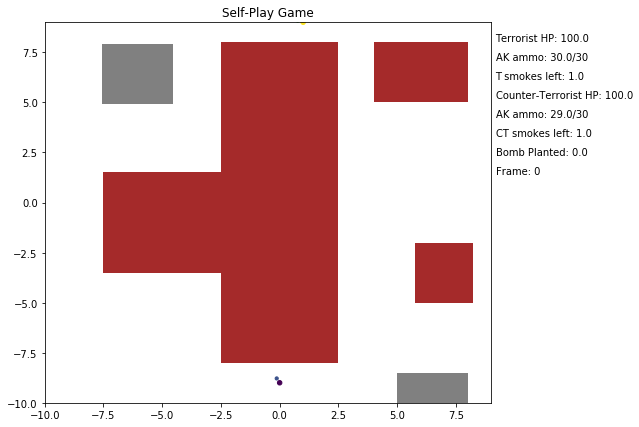

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import animation, rc
from IPython.display import HTML
import time
rc('animation', html='jshtml')

offsets, colors, ammo, smoke_equip, plant_equip, Map, PPO_data = simulate_game(fmodel, gmodel, hmodel, tnodes=0, ctnodes=0, 
                                                                               frames=100, verbose=True, dirichlet=False, temp=1.0)
frames = int(len(PPO_data[1])/2)
interval = frames
#offsets = np.array(offsets)
#colors = np.array(colors)
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlim((-Map.size, Map.size-1))
ax.set_ylim((-Map.size, Map.size-1))

for box in Map.boxes:
    color = "brown"
    if box.passable:
        color = "grey"
    rect = plt.Rectangle((box.x - box.w/2, box.y - box.h/2), box.w, box.h, fc=color)
    plt.gca().add_patch(rect)



box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # Shrink current axis by 20%
counts = [ax.text(1.01, 0.95-i*0.05,  '', transform=ax.transAxes) for i in range(8)]
scat = plt.scatter(np.zeros(4), np.zeros(4), c=[200, 0, 150, 50], s=[20, 20, 10, 10])
plt.title("Self-Play Game")
anim = animation.FuncAnimation(fig, update_plot, frames=frames,
                              fargs=(offsets, colors, ammo, smoke_equip, plant_equip, scat), interval=interval)

In [21]:
anim

In [34]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=4.0, metadata=dict(artist='Me'), bitrate=1800)
anim.save('selfplay.mp4', writer=writer)


(1, 20, 20, 28)
('fire', 0) :  0.014146856
('fire', 40) :  0.015857859
('fire', 80) :  0.017166147
('fire', 120) :  0.016599089
('fire', 160) :  0.014514685
('fire', 200) :  0.01789018
('fire', 240) :  0.014634781
('fire', 280) :  0.017047634
('fire', 320) :  0.016290924
('up', 0) :  0.013614368
('up', 40) :  0.016399346
('up', 80) :  0.017298834
('up', 120) :  0.01765693
('up', 160) :  0.015168682
('up', 200) :  0.014798994
('up', 240) :  0.015617793
('up', 280) :  0.016479041
('up', 320) :  0.015179596
('down', 0) :  0.015229197
('down', 40) :  0.014426635
('down', 80) :  0.018008059
('down', 120) :  0.016044037
('down', 160) :  0.015585554
('down', 200) :  0.014195839
('down', 240) :  0.017386597
('down', 280) :  0.015439615
('down', 320) :  0.016767086
('left', 0) :  0.017053833
('left', 40) :  0.013262846
('left', 80) :  0.015665783
('left', 120) :  0.01600838
('left', 160) :  0.015065884
('left', 200) :  0.014522866
('left', 240) :  0.015360667
('left', 280) :  0.01679
('left', 3

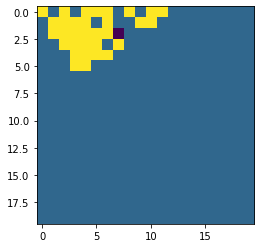

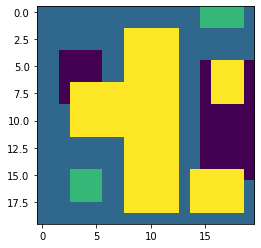

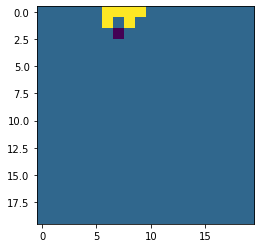

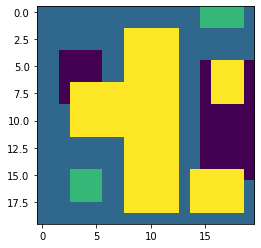

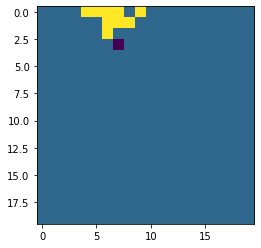

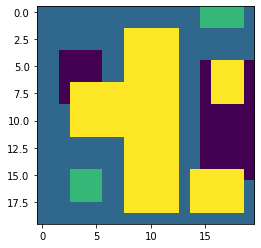

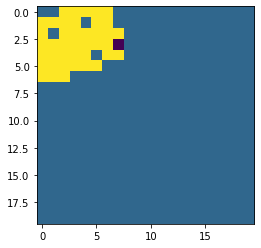

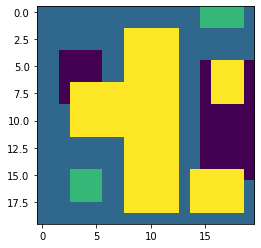

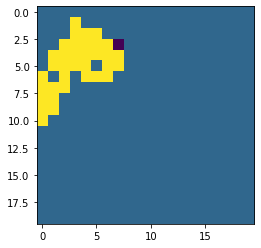

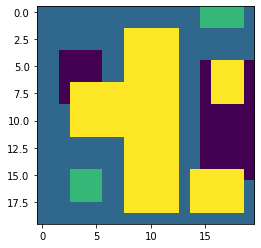

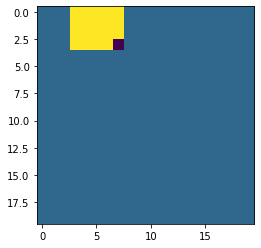

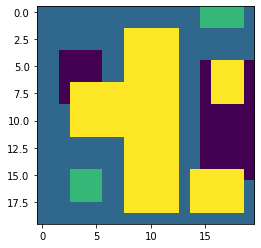

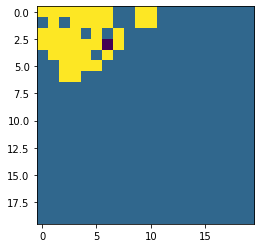

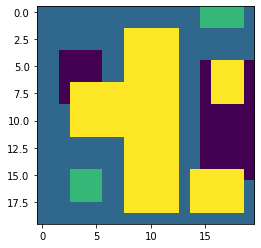

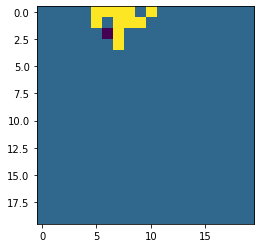

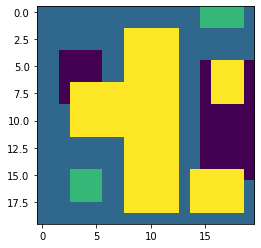

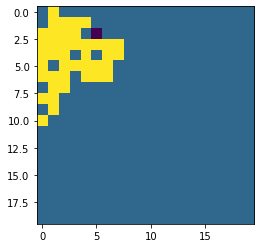

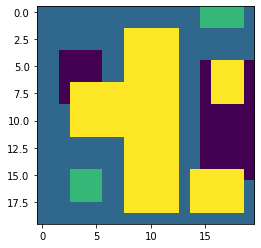

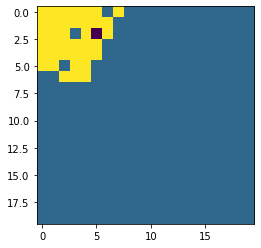

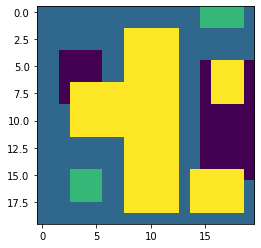

In [45]:
t = 55*2 + 1
print(PPO_data[0][t].shape)
np.set_printoptions(threshold=30000)
inp = np.swapaxes(PPO_data[0][t], 3, 1)[0]
for index in range(63):
    prob = PPO_data[2][t][0][index]
    if prob > 0:
        print(index_action(index), ": ", prob)
print("Taken: ", index_action(np.argmax(PPO_data[3][t])))
for i in range(20):
    plt.imshow(inp[i])
    plt.show()


In [23]:
old = PPO_data[4]
new = PPO_data[5]

In [28]:
index = 100
print("Old Latent: ")
print(old[index])
print("Predicted New: ")
action = PPO_data[7][index]
pred_new = hmodel.predict([old[index], np.reshape(action, [-1, 63])])
print(pred_new)
print("Actual New: ")
print(new[index])
print("MSE: ")
print(np.sum(np.square(pred_new - new[index])))

Old Latent: 
[[ 0.99604243 -0.9987421   0.9999991   0.99999857 -0.991753    1.
   1.         -0.99999994  0.9999771  -0.9999699   0.9999867  -0.8878322
   0.986726    0.999992   -0.99989605 -0.99998516  0.51918423 -0.9897354
  -0.9999942   0.9999998  -1.          0.9999803  -0.92910594 -0.9999833
   0.9999978  -0.9999848  -0.9999983   0.9999984  -0.9999959  -0.9999827
   0.9999885  -0.9999998  -0.9999675  -0.99992734 -1.          0.9811508
   0.9999976  -0.99999994 -0.99994934 -0.9999881  -1.         -0.95101744
   0.9999954   0.99516076  0.9999987   1.         -0.9992393   1.
   0.9999998   0.96937066]]
Predicted New: 
[[ 0.9963504  -0.9987432   0.9999993   0.99999857 -0.99192727  1.
   1.         -1.          0.9999771  -0.9999887   0.9999867  -0.89078707
   0.9872229   0.999992   -0.9998967  -0.99998534  0.520539   -0.9892457
  -0.9999965   0.9999998  -1.          0.99998033 -0.9293776  -0.9999833
   0.99999774 -0.99998534 -0.9999983   0.99999845 -0.9999961  -0.9999833
   0.9999885 